In [1]:
using LinearAlgebra
using FFTW
using Random
using CairoMakie

The purpose of this notebook is to determine some phase competition between 3 phases:
- Symmetric phase
- Time-reversal breaking phase
- Time-reversal + translation breaking phase

The relevant Hamiltonian is $H = \hbar v_F (k_x \sigma^y - k_y \sigma^x) + \lambda _1 \sigma^z + \lambda _2 \sum_{i = 1}^3 cos(r \cdot G_i)$. 
- $\hbar v_F (k_x \sigma^y - k_y \sigma^x)$ is the Rashba SOC found on the surface of a 3D TI. This term acts as the kinetic energy.
- $\lambda _1 \sigma^z$ is a mass term that gaps out the Dirac cone. This term breaks time-reversal symmetry.
- $\lambda _2 \sum_{i = 1}^3 cos(r \cdot G_i)$ is a periodic potential that favors crystalization in a hexagonal pattern. This term encourages breaking of translation symmetry.

In [93]:
# constants
hbar = 1.0545718e-34  # Reduced Planck constant
e = 1.6e-19  # Electron charge
epsilon = 10  # Dielectric constant
v_F = 1.0 # Dirac velocity
a = 1 # lattice constant
lambda_1 = 1 # time-reversal breaking strength
lambda_2 = 2 # translation-breaking strength

2

In [94]:
G1 = [2*pi/a, -2*pi/(sqrt(3) * a)]
G2 = [0, 2*pi/a * 2/sqrt(3)]
# high-symmetry points
kappa_1 = (2/3) * G1 + (1/3) * G2
kappa_3 = kappa_1 - (G1 + G2)
kappa_5 = kappa_1 + G1

2-element Vector{Float64}:
 10.471975511965976
 -3.6275987284684357

In [95]:
# uniform disk of points
function disk(n, r)
    points = Array{Float64}(undef, n, 2)
    for i in 1:n
        theta = 2 * pi * rand()
        rho = r * sqrt(rand())
        x = rho * cos(theta)
        y = rho * sin(theta)
        points[i, :] = [x, y]
    end
    return points
end

disk (generic function with 2 methods)

In [96]:
# 2x2 Pauli X
function sigma_x()
    return [0 1; 1 0]
end
# 2x2 Pauli Y
function sigma_y()
    return [0 -im; im 0]
end
# 2x2 Pauli Z
function sigma_z()
    return [1 0; 0 -1]
end

sigma_z (generic function with 1 method)

In [97]:
# Kinetic term in spin-space
function H_0(kx, ky, hbar, vF)
    return hbar * vF * (kx * sigma_y() - ky * sigma_x())
end

H_0 (generic function with 1 method)

In [98]:
# Going to make a crude approximation that potential at K-points >> 
# potential everyhere else
function ham_3(kx, ky, hbar, vF, lambda1, lambda2, k1, k2, k3)
    h1 = H_0(kx + k1[1], ky + k1[2], hbar, vF)
    h2 = H_0(kx + k2[1], ky + k2[2], hbar, vF)
    h3 = H_0(kx + k3[1], ky + k3[2], hbar, vF)
    H_temp = kron(h1, [1 0 0; 0 0 0; 0 0 0]) + kron(h2, [0 0 0; 0 1 0; 0 0 0]) + 
    kron(h3, [0 0 0; 0 0 0; 0 0 1])
    H_temp += kron(lambda1 * sigma_z(), [1 0 0; 0 1 0; 0 0 1])
    # periodic potential
    h_connect = [0 lambda2 lambda2; conj(lambda2) 0 lambda2; 
    conj(lambda2) conj(lambda2) 0]
    H_temp += kron([1 0; 0 1], h_connect)
    return H_temp
end

ham_3 (generic function with 1 method)

In [99]:
# Kinetic/volume for symmetric phase
function K1(hbar, vF, lambda, N)
    points = disk(N, lambda)
    T_energy = 0
    for i in 1:N
        kx = points[i, 1]
        ky = points[i, 2]
        ham0 = H_0(kx, ky, hbar, vF)
        values = eigvals(Hermitian(ham0))
        T_energy += values[1]
    end
    return T_energy
end

K1 (generic function with 1 method)

In [100]:
# Kinetic/volume for time-reversal breaking phase
function K2(hbar, vF, lambda, N, lambda1)
    points = disk(N, lambda)
    T_energy = 0
    for i in 1:N
        kx = points[i, 1]
        ky = points[i, 2]
        ham0 = H_0(kx, ky, hbar, vF)
        ham1 = ham0 + lambda1 * sigma_z()
        gs = eigvecs(Hermitian(ham1))[:, 1]
        T_energy += dot(gs, ham0 * gs)
    end
    return T_energy
end

K2 (generic function with 1 method)

In [101]:
# Kinetic/volume for time-reversal breaking and translation breaking phase
function K3(hbar, vF, lambda, N, lambda1, lambda2, k1, k2, k3)
    points = disk(N, lambda)
    T_energy = 0
    for i in 1:N
        kx = points[i, 1]
        ky = points[i, 2]
        # make kinetic operator
        h1 = H_0(kx + k1[1], ky + k1[2], hbar, vF)
        h2 = H_0(kx + k2[1], ky + k2[2], hbar, vF)
        h3 = H_0(kx + k3[1], ky + k3[2], hbar, vF)
        H_kin = kron(h1, [1 0 0; 0 0 0; 0 0 0]) + kron(h2, [0 0 0; 0 1 0; 0 0 0]) + 
        kron(h3, [0 0 0; 0 0 0; 0 0 1])
        # find GS
        ham3 = ham_3(kx, ky, hbar, vF, lambda1, lambda2, k1, k2, k3)
        gs = eigvecs(Hermitian(ham3))[:, 1]
        T_energy += dot(gs, H_kin * gs)
    end
    return T_energy
end


K3 (generic function with 1 method)

In [ ]:
function hartree_1(hbar, vF, lambda, N, )

<font size="12">HF Plots</font>

Phase competition between 2 phases:
- Symmetric phase
- Time-reversal breaking phase

The relevant Hamiltonian is $H = \hbar v_F (k_x \sigma^y - k_y \sigma^x) + \frac{\lambda _1}{k} \sigma^z$. 
- $\hbar v_F (k_x \sigma^y - k_y \sigma^x)$ is the Rashba SOC found on the surface of a 3D TI. This term acts as the kinetic energy.
- $\frac{\lambda _1}{k} \sigma^z$ is a mass term that gaps out the Dirac cone. This term breaks time-reversal symmetry.

In [48]:
alpha = 1 # fine-structure constant
epsilon = 1 # dielectric constant
c = 1 # speed of light
m = 0.0001 # Dirac mass
hbar = 1

1

In [139]:
# set momentum cutoffs
Lambda_down = 1
Lambda_up = 0

0

In [140]:
function rs_H0(alpha, epsilon, c, vF)
    return (3/4) * (alpha / epsilon) * (c / vF)
end

rs_H0 (generic function with 1 method)

In [141]:
# HF energy-density in ground state of Rashba Hamiltonian
function E_H0(alpha, epsilon, c, hbar, vF, L_up, L_down)
    return 1/(24*pi * epsilon) * (-3 * c * alpha * hbar * (L_down^3 + L_up^3) + 
    4 * epsilon * hbar * vF * (L_up^3 - L_down^3))
end

E_H0 (generic function with 1 method)

In [142]:
# HF energy-density in ground state of Rashba Hamiltonian + Dirac mass
function E_H1(alpha, epsilon, c, hbar, vF, m, L_up, L_down)
    return 1/(3840 * pi * m^2 * epsilon) * 
    (-120 * alpha * c * hbar * m^2 * (L_up^3 + L_down^3) + 
    640 * hbar * vF * epsilon * m^2 * (L_up^3 - L_down^3) - 
    25 * alpha * c * hbar^3 * vF^2 * (L_up^5 + L_down^5) + 
    192 * hbar^3 * vF^3 * (L_down^5 - L_up^5))
end

E_H1 (generic function with 1 method)

In [143]:
samps = 1000
vF_range = range(10^(-3), 0.15, samps)

0.001:0.00014914914914914914:0.15

In [144]:
H0_energies = Array{Float64}(undef, samps)
H1_energies = Array{Float64}(undef, samps)
for i in 1:samps
    v_F = vF_range[i]
    H0_energies[i] = E_H0(alpha, epsilon, c, hbar, v_F, Lambda_up, Lambda_down)
    H1_energies[i] = E_H1(alpha, epsilon, c, hbar, v_F, m, Lambda_up, Lambda_down)
end

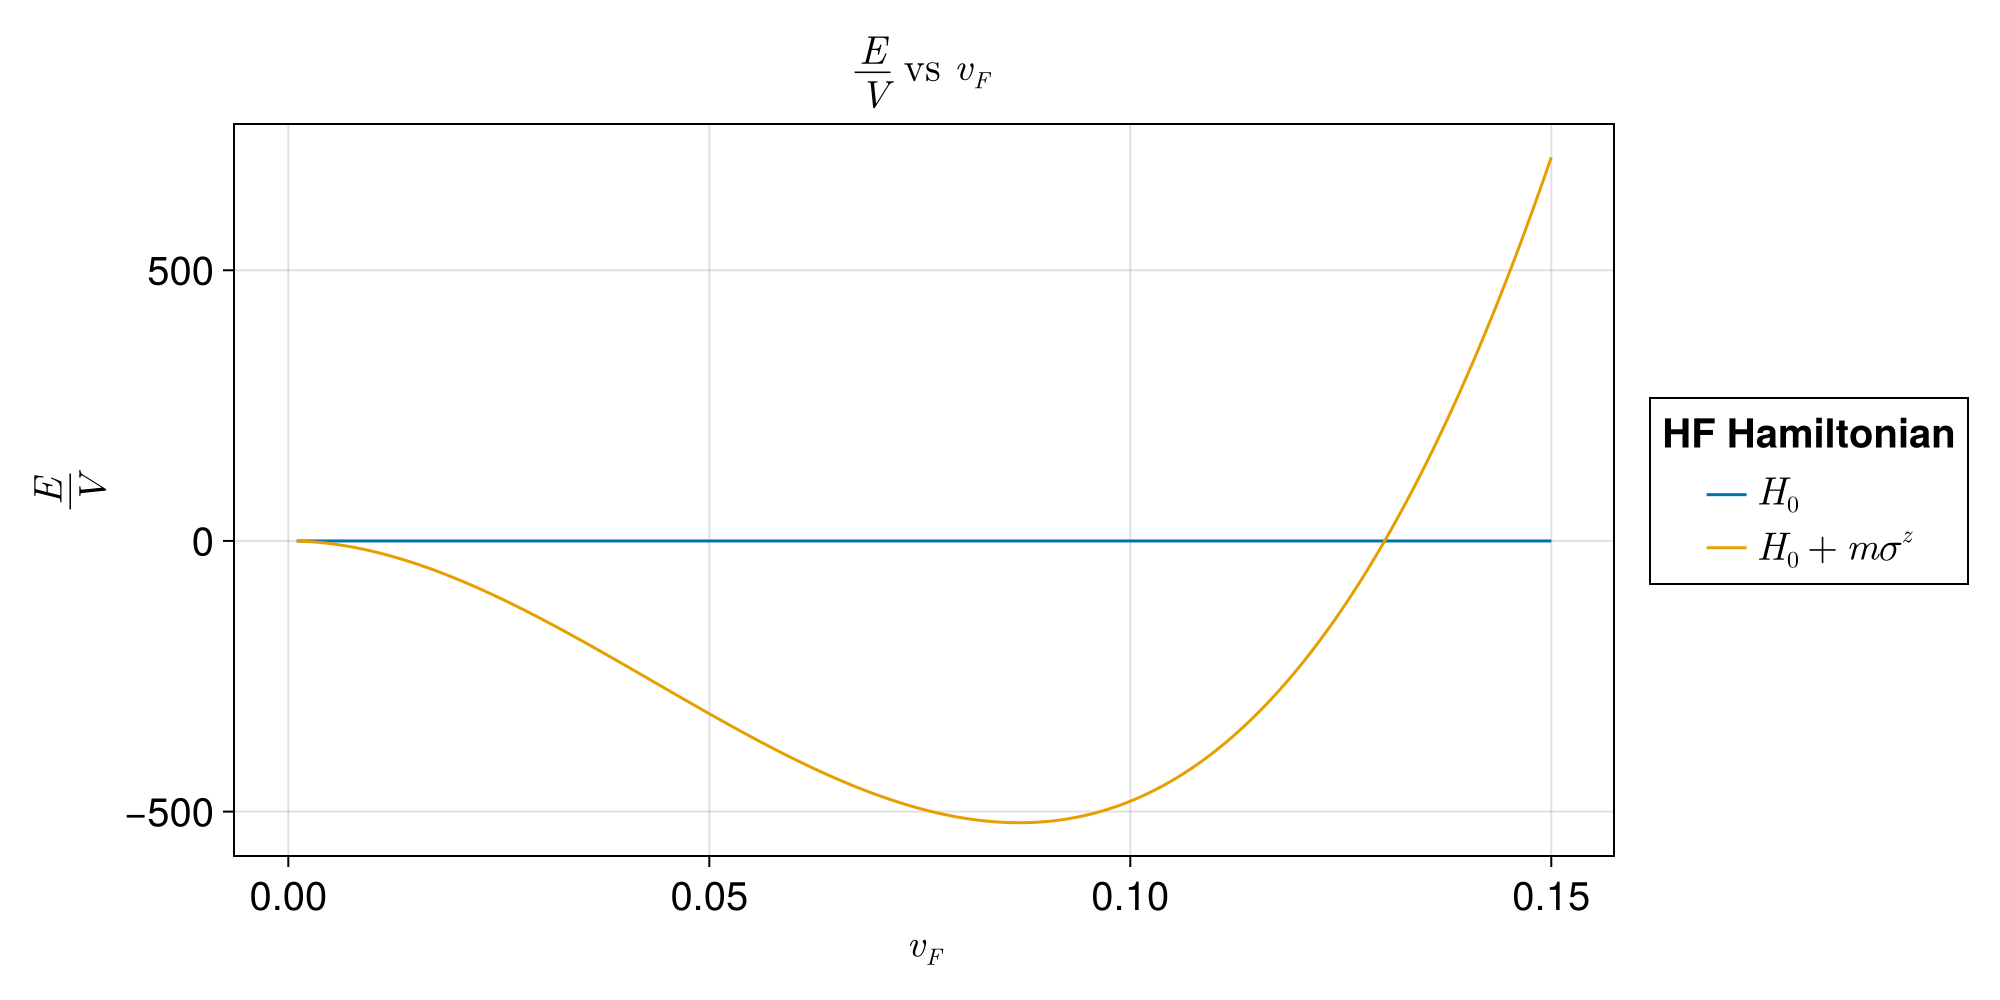

In [145]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax = Axis(P[1, 1], title = L"\frac{E}{V} \ \text{vs} \ v_F", xlabel = L"v_F", ylabel = L"\frac{E}{V}")
lines!(ax, vF_range, H0_energies, label = L"H_0")
lines!(ax, vF_range, H1_energies, label = L"H_0 + m \sigma^z")
# create and configure legend
P[1, 2] = Legend(P, ax, "HF Hamiltonian", framevisible = true)
P